<a href="https://colab.research.google.com/github/mspatke/Deep-Learning-with-Tensorflow/blob/main/Flower_dataset_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [8]:
(training_set, validation_set), dataset_info = tfds.load('tf_flowers', split= ['train[:70%]', 'train[70%:]'], with_info = True, as_supervised=True)

In [9]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples +=1

for example in validation_set:
  num_validation_examples +=1


print('Total No of classes: {}'.format(num_classes))
print('Total no of training images: {}'.format(num_training_examples))
print('Total no of training images: {}'.format(num_validation_examples))


Total No of classes: 5
Total no of training images: 2569
Total no of training images: 1101


In [10]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label {}'.format( i+1, example[0].shape, example[1]))
  

Image 1 shape: (333, 500, 3) label 2
Image 2 shape: (212, 320, 3) label 3
Image 3 shape: (240, 320, 3) label 3
Image 4 shape: (240, 320, 3) label 4
Image 5 shape: (317, 500, 3) label 3


In [11]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [12]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL,input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [14]:
feature_extractor.trainable = False

In [15]:
model = tf. keras.Sequential([ feature_extractor, 
                              layers.Dense(num_classes)])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [20]:
model.compile(
    optimizer ='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
    )


EPOCHS = 6

history = model.fit(train_batches,
                    epochs = EPOCHS ,
                    validation_data = validation_batches)

Epoch 1/6
81/81 [==============================] - 18s 63ms/step - loss: 0.7553 - accuracy: 0.7186 - val_loss: 0.4452 - val_accuracy: 0.8583
Epoch 2/6
81/81 [==============================] - 4s 50ms/step - loss: 0.3792 - accuracy: 0.8797 - val_loss: 0.3816 - val_accuracy: 0.8738
Epoch 3/6
81/81 [==============================] - 4s 50ms/step - loss: 0.3034 - accuracy: 0.9070 - val_loss: 0.3231 - val_accuracy: 0.8983
Epoch 4/6
81/81 [==============================] - 4s 50ms/step - loss: 0.2512 - accuracy: 0.9237 - val_loss: 0.3021 - val_accuracy: 0.8992
Epoch 5/6
81/81 [==============================] - 4s 50ms/step - loss: 0.2130 - accuracy: 0.9342 - val_loss: 0.2981 - val_accuracy: 0.8983
Epoch 6/6
81/81 [==============================] - 4s 51ms/step - loss: 0.1880 - accuracy: 0.9475 - val_loss: 0.2856 - val_accuracy: 0.9037


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location ' Lower Right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Unrecognized location ' Upper Right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


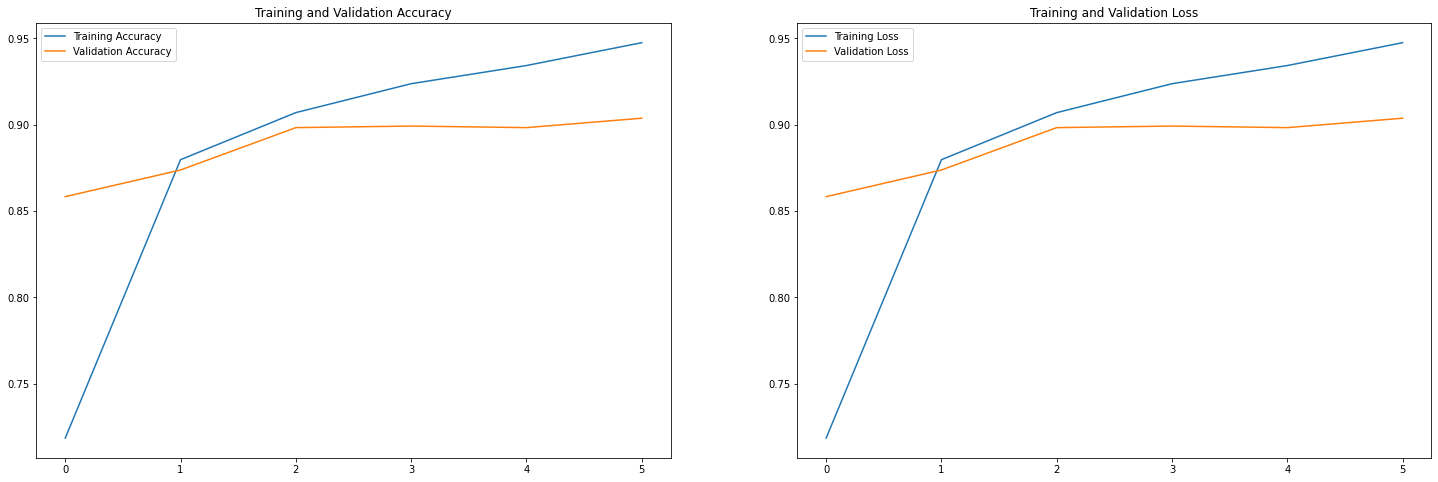

In [24]:
#Plot training and validation Graph

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(25,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label ='Validation Accuracy')
plt.legend(loc=' Lower Right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, acc, label='Training Loss')
plt.plot(epochs_range, val_acc, label ='Validation Loss')
plt.legend(loc=' Upper Right')
plt.title('Training and Validation Loss')
plt.show()


In [25]:
class_names = np.array(dataset_info.features['label'].names)

print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [26]:
image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis =-1)
predicted_class_name = class_names[predicted_ids]

print(predicted_class_name)

['daisy' 'sunflowers' 'roses' 'roses' 'dandelion' 'dandelion' 'roses'
 'roses' 'roses' 'roses' 'daisy' 'daisy' 'tulips' 'sunflowers'
 'sunflowers' 'daisy' 'sunflowers' 'tulips' 'daisy' 'roses' 'sunflowers'
 'roses' 'roses' 'tulips' 'roses' 'daisy' 'roses' 'roses' 'dandelion'
 'roses' 'sunflowers' 'sunflowers']


In [27]:
#Print True Labels and Predicted labels

print("Labels : ", label_batch)
print("Predicted labels : ", predicted_ids)


Labels :  [1 3 4 4 0 0 4 4 4 4 1 1 2 3 3 1 3 2 1 4 3 4 4 2 4 1 4 4 0 4 3 3]
Predicted labels :  [1 3 4 4 0 0 4 4 4 4 1 1 2 3 3 1 3 2 1 4 3 4 4 2 4 1 4 4 0 4 3 3]


In [34]:
from tensorflow.python.framework import tensor_util
#Transfer Learning with inception model

IMAGE_RES = 299

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    with_info= True,
    as_supervised= True,
    split= ['train[:70%]', 'train[70%:]']
)

In [35]:
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [37]:
URL_Inception = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extracter = hub.KerasLayer(URL_Inception,
                                   input_shape=(299, 299 , 3),
                                   trainable= False)

model_inception = tf.keras.Sequential([feature_extracter,
                                       tf.keras.layers.Dense(num_classes) ])


model_inception.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_4 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [39]:
model_inception.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics= ['accuracy']
)

EPOCHS= 6

history = model_inception.fit(train_batches,
                              epochs = EPOCHS,
                              validation_data = validation_batches)

Epoch 1/6
81/81 [==============================] - 23s 199ms/step - loss: 0.7887 - accuracy: 0.7069 - val_loss: 0.4775 - val_accuracy: 0.8583
Epoch 2/6
81/81 [==============================] - 14s 176ms/step - loss: 0.4022 - accuracy: 0.8762 - val_loss: 0.3902 - val_accuracy: 0.8765
Epoch 3/6
81/81 [==============================] - 14s 177ms/step - loss: 0.3237 - accuracy: 0.8992 - val_loss: 0.3359 - val_accuracy: 0.8837
Epoch 4/6
81/81 [==============================] - 13s 163ms/step - loss: 0.2702 - accuracy: 0.9167 - val_loss: 0.3103 - val_accuracy: 0.8919
Epoch 5/6
81/81 [==============================] - 14s 179ms/step - loss: 0.2371 - accuracy: 0.9299 - val_loss: 0.2989 - val_accuracy: 0.8946
Epoch 6/6
81/81 [==============================] - 13s 164ms/step - loss: 0.2079 - accuracy: 0.9424 - val_loss: 0.2864 - val_accuracy: 0.8974


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location ' Lower Right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Unrecognized location ' Upper Right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


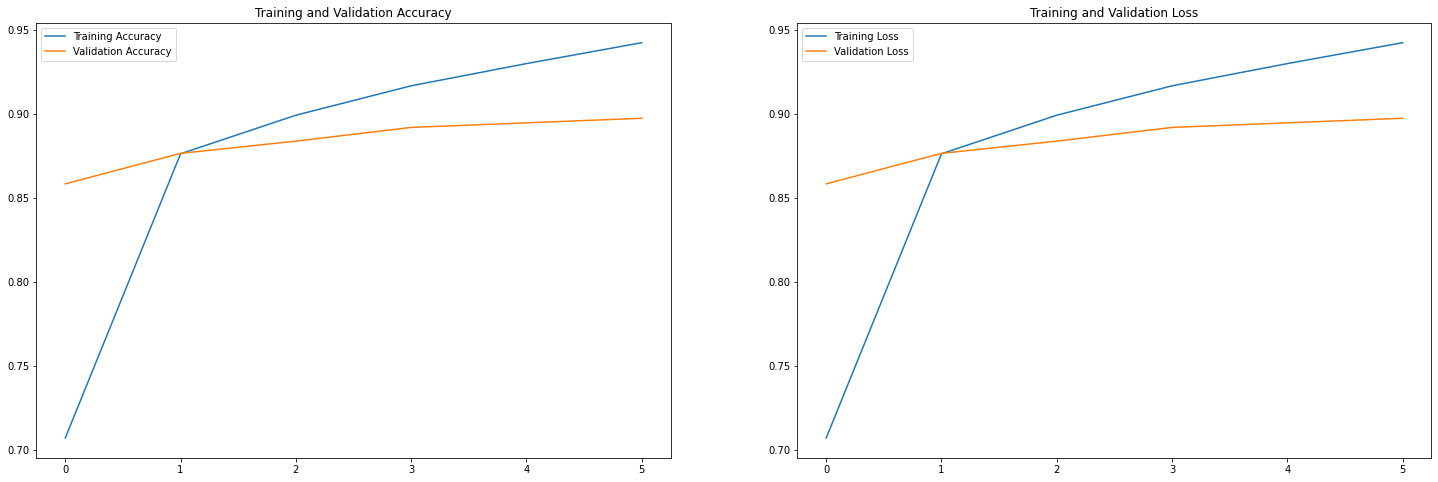

In [40]:
#Plot training and validation Graph

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(25,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label ='Validation Accuracy')
plt.legend(loc=' Lower Right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, acc, label='Training Loss')
plt.plot(epochs_range, val_acc, label ='Validation Loss')
plt.legend(loc=' Upper Right')
plt.title('Training and Validation Loss')
plt.show()
